# <p style="text-align:center;"><strong><u>MovieLens Tagging Data Research</u></strong></p>
## This notebook demonstrates my research for the MovieLens group where we try to connect movie tags to movie recommendations. The overall end goal of this project is to be able to recommend movies based on which tags the users on the MovieLens website are having a positive interaction with. This means that a user puts a "+1" for that tag on that specific movie. 

###  </u> <p style="text-align:center;"><strong><u>10/26-11/16/23</u></strong></p>

##### Shown below is the code that I wrote when I tried to correlate user-affect interaction with the names of different actors/actresses. We tried looking through this through random "active" movie data to see if there was sufficient "starter" data for the tagging system. By doing this we are hoping we could dive deeper into this aspect of the database to have a better understanding of how to recommend movies that users could like. 

In [18]:
import mysql.connector
import csv
import random

def get_user_input():
    while True:
        try:
            num_movies = int(input("Enter the number of movies you want to print: "))
            if num_movies > 0:
                return num_movies
            else:
                print("Please enter a positive number.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

db_config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "",
    "database": "ML3_mirror"
}

conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

movies = []

# Fetches movie data
query = "SELECT movieID, title, directedBy, starring FROM movie_data WHERE movieStatus = 2 AND rowType = 11"
cursor.execute(query)

# Loops through movies to get title, directedBy, and Starring within the database
for (movieID, title, directedBy, starring) in cursor:
    movie_info = {
        "movieID": movieID,
        "title": title,
        "directedBy": directedBy.split(", "),
        "starring": starring.split(", ")
    }
    movies.append(movie_info)

# Gets the number of movies the user wants to print
num_movies_to_print = get_user_input()

# Ensures at least num_movies_to_print unique movies are selected
selected_movies = random.sample(movies, num_movies_to_print)

# Writes statistics for the selected random movies and relevant tags to a CSV file
csv_filename = "random_movies_statistics.csv"

with open(csv_filename, "w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)

    # Writes header
    csv_writer.writerow(["Movie Title", "Tag", "Affect Percentage"])

    # Loops through each random movie
    for movie in selected_movies:
        movie_title = movie["title"]

        tag_stats = {}

        # Fetches tag data for the current movie and actors
        query = f"SELECT tag, uniqueUsers, totalPositive FROM tag_data WHERE tag IN ({', '.join(['%s']*len(movie['starring']))})"
        cursor.execute(query, movie['starring'])

        # Gets tag, uniqueUsers, and totalPositive values for the current movie
        for (tag, uniqueUsers, totalPositive) in cursor:
            tag_stats[tag] = {
                "uniqueUsers": uniqueUsers,
                "totalPositive": totalPositive,
            }

        # Checks if there are tags related to the actors and actresses in the selected movie
        if not tag_stats:
            # Writes a row to the CSV file indicating no tags were found for the actors in the movie
            csv_writer.writerow([movie_title, "No tags found", "N/A"])
            continue

        user_affect = {}

        # Calculates user influence for the current movie
        for actor in movie["starring"]:
            for tag, stats in tag_stats.items():
                if actor in tag:
                    user_affect[tag] = (
                        user_affect.get(tag, 0) + (stats["totalPositive"] / stats["uniqueUsers"])
                    )

        user_total_affect = sum(user_affect.values())

        # Calculates the percentage of influence for each tag
        user_percentage_influence = {}
        if user_total_affect != 0:
            user_percentage_influence = {
                tag: round((influence / user_total_affect) * 100, 2) for tag, influence in user_affect.items()
            }

        # Writes data for each tag that includes an actor's or actress's name
        for tag, percentage in user_percentage_influence.items():
            csv_writer.writerow([movie_title, tag, '{:.2f}'.format(percentage)])

# Closes the database connection
cursor.close()
conn.close()

print(f"Statistics for {num_movies_to_print} random movies written to {csv_filename}")

Statistics for 5 random movies written to random_movies_statistics.csv


In [19]:
import pandas as pd 

In [20]:
data = pd.read_csv("random_movies_statistics.csv")

#### Shown below is the resulting csv file that is outputed with the title of the random movie selected, the tags that were interacted with and the percentage of user-interaction with that tag out of all the tags on that movie.

In [21]:
data.head(30)

,Movie Title,Tag,Affect Percentage
0,Queen Bee (1955),Joan Crawford,100.00
1,Queen Bee (1955),Betsy Palmer,0.00
2,Flesh & Blood (1985),Rutger Hauer,51.30
3,Flesh & Blood (1985),Jennifer Jason Leigh,48.70
4,Flesh & Blood (1985),Tom Burlinson,0.00
5,Flesh & Blood (1985),Jack Thompson,0.00
6,V/H/S (2012),Adam Wingard,17.65
7,V/H/S (2012),Hannah Fierman,29.41
8,V/H/S (2012),Joe Swanberg,23.53
9,V/H/S (2012),Kate Lyn Sheil,0.00


### </u> <p style="text-align:center;"><strong><u>12/1/23-5/9/24</u></strong></p>

##### As of right now, since we figured out there is clear evidence of sufficient tag data to use for movie recommendation we are attempting to deeper into finding a way to connect the results of tag interactions with another category to recommend movies effectively to users. Below is shown my previous proposal from 12/1/23, and then we had gone on Winter Break and I had not really done anything after the meeting nor have we had another meeting yet.

### Question That is Being Asked: 
     What is the meaning of the valence/total Application of tags in the database?

### Findings: 
    From what I've found in the databases, it appears that when diving deeper into specific tables, the meaning behind numNuetral, numPosiitve, and numNegative is the number of possibilities of effects for each tag. That means that there is only one option for each which means you felt neutral, positive, or Negative for each tag. I tried selecting the counts for what affect through the tag_events table. I believe that this is just the total amount of times that the affect was used for all tags in all of the movies. I'm not exactly sure if this is the correct interpretation of what I was trying to do, or whether or not this is what Daniel had asked for at the last meeting, but this is how I understood it. I would love it if somebody from the last meeting would give me feedback on whether or not this is correct. 
### Proposal for Moving Forward: 
    I think that moving forward, it would be interesting to move forward with the idea of figuring out how we can suggest movies based on how users are using the affect on tags. For example, if a user puts a +1 for a tag, then we can use that in-time data to affect the "we think you'd like these movies" section of the website and then it would give movies with that exact tag or similar tags. If a user puts a -1 for a tag then we would find movies that have tags that are opposite of that tag that the user didn't like. If a user uses the neutral affect on the tag then there would be no effect on which movies are recommended. 

#### New proposal as of 1/22/24

##### What if we looked at not only the tags in general but maybe tried to look at more specifically the tags throughout specific genres? We could try to see if there is a similarity in tags for example between actors, themes in movies, or other types of tags in specific genres of movies. Then we could try to recommend movies to users who liked movies in that genre based on the tag that they liked. For example, say John Doe was a tag for one of the movies and then the user puts a "+1" for that tag. Then on the homepage, there could be a section that loads other movies of that genre containing that John Doe tag. I think we have usable the data for this as we have the movie genre data and the tag data in our database. With that data, we can essentially loop through all the different active movies throughout the different genres using real-time user interactions with tags to keep updating the homepage with different tags. 

### Proposal from 2/9 to figure out how to predicit which tags the user might like

**Goal:**
Predict the tags a user will likely prefer based on their past ratings, and estimate what rating they would assign to those tags.

**Proposal for an Equation:**
##### Let's propose a simple equation to calculate the predicted score using the userID, tag, and specific movie $$( S_{ui} )$$ for a $$user ( u )$$ and a $$tag ( i )$$

$$  S_{ui} = \frac{\sum_{j} R_{uj} \cdot W_{ji}}{\sum_{j} |W_{ji}|} $$

#### Where:
##### $$  R_{uj}$$ represents the score that user $$ u $$ has given to movie $$ j $$
#### $$ W_{ji}$$ represents the weight of tag $$ i $$ associated with movie $$ j $$

**Summation Equation:**
#### The summation equation calculates the predicted valence for a user-tag pair by summing the product of the user's ratings for each movie and the weights of the corresponding tags, normalized by the sum of absolute weights.

**Linear Regression Equation:**
##### For a more detailed approach, we can use linear regression to predict user preferences. The linear regression equation would look like:

$$  S_{ui} = \beta_0 + \beta_1 R_{ui} + \epsilon_{ui} $$

### Where:
- ##### $$ S_{ui}$$ is the predicted score for user "u" and tag  "i".
- ##### $$ R_{ui}$$ is the rating given by user "u"  for tag  "i".
- $$ \beta_0 $$ is the intercept.
- $$ \beta_1 $$ is the coefficient for the rating.
- $$ \epsilon_{ui}$$ is the error term.

### My userId is 402850 and Daniel's is 176653, seby's userId is 405309, Ian's is 86716, Romeo's is 407599  tag_events table not tag_ratings, tag_events is the actual ratings of which tag users are interacting with and tag_ratings are just tags that people think that don't apply to movies

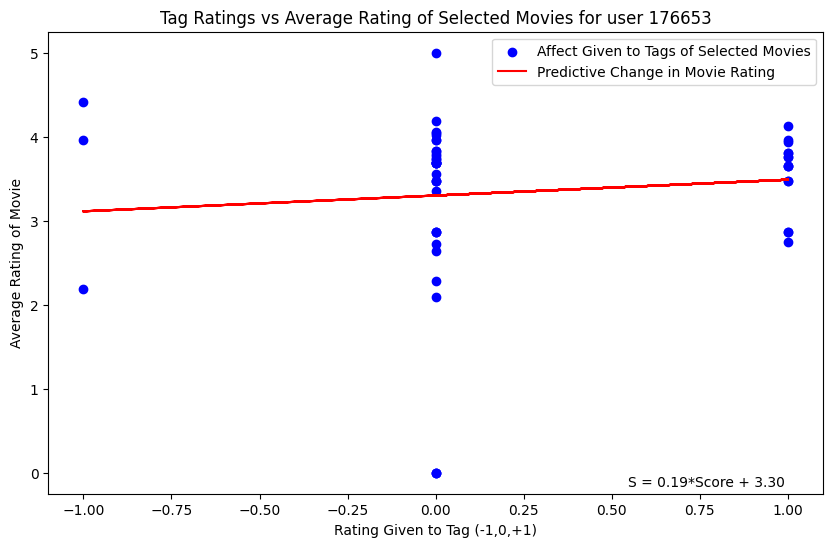

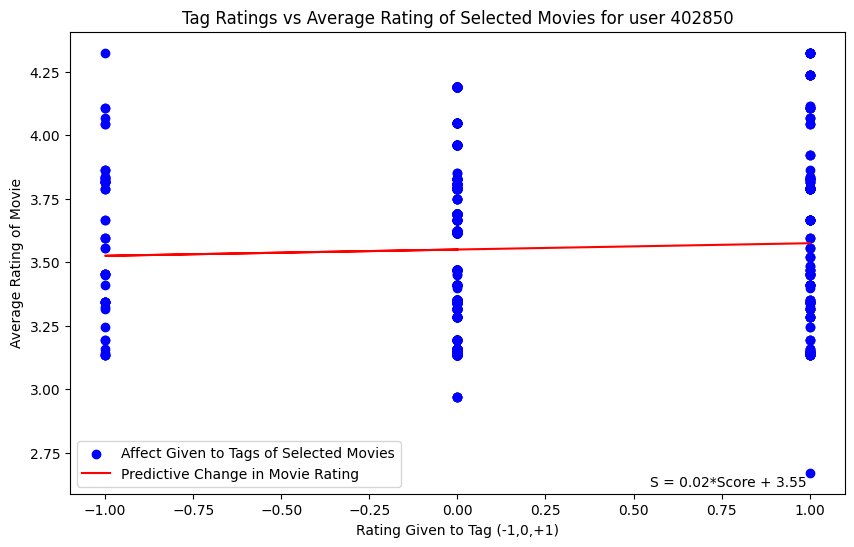

No data found for user_id 86716. Skipping...


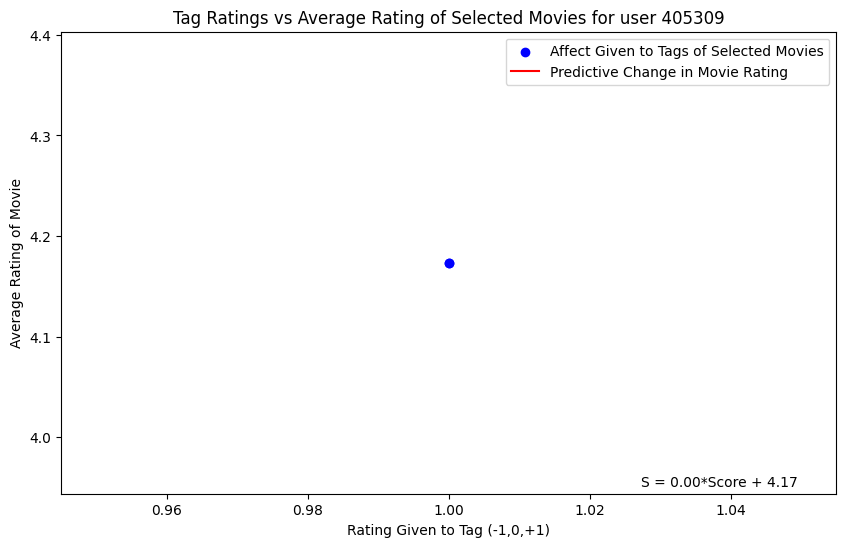

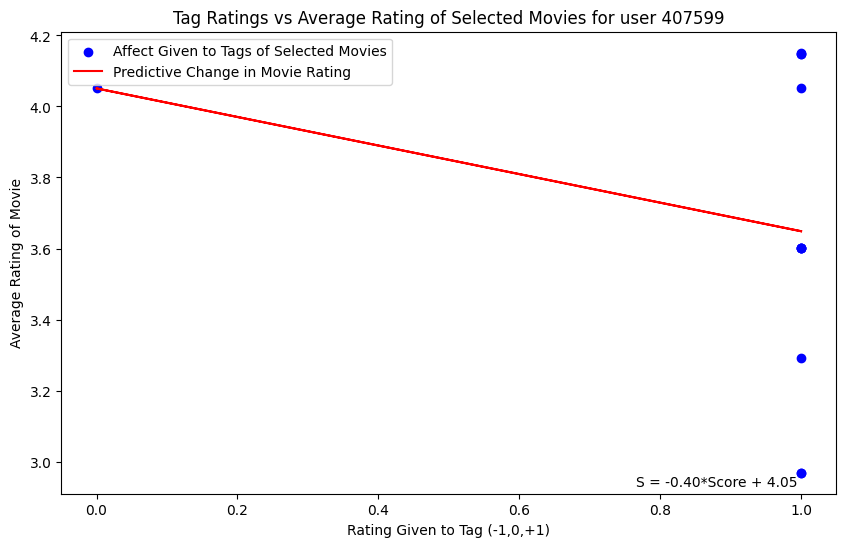

MySQL connection is closed


In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import Error

def calculate_valence(user_id, engine):
    try:
        sql_query = f"""
        SELECT movie_data.movieId, movie_data.title, movie_data.avgRating, tag_events.userId, tag_events.tag, tag_events.affect AS score
        FROM movie_data
        JOIN tag_events ON movie_data.movieId = tag_events.movieId
        WHERE tag_events.userId = {user_id}
        """
        
        df = pd.read_sql(sql_query, engine)
        
        if df.empty:
            print(f"No data found for user_id {user_id}. Skipping...")
            return
        
       
        X = df[['score']]  # Independent variable
        y = df['avgRating']  # Dependent variable

        model = LinearRegression()
        model.fit(X, y)

        beta_0 = model.intercept_
        beta_1 = model.coef_[0]
        
        df['predicted_avgRating'] = model.predict(X)

        plt.figure(figsize=(10, 6))
        plt.scatter(df['score'], df['avgRating'], color='blue', label='Affect Given to Tags of Selected Movies')
        plt.plot(df['score'], df['predicted_avgRating'], color='red', label='Predictive Change in Movie Rating')

        
        equation_text = f'S = {beta_1:.2f}*Score + {beta_0:.2f}'
        plt.text(0.95, 0.01, equation_text, ha='right', va='bottom', transform=plt.gca().transAxes)

        plt.title(f'Tag Ratings vs Average Rating of Selected Movies for user {user_id}')
        plt.xlabel('Rating Given to Tag (-1,0,+1)')
        plt.ylabel('Average Rating of Movie')
        plt.legend()
        plt.show()
        
    except Error as e:
        print(f"Error: {e}")

def main():
    user_ids = [176653, 402850, 86716, 405309, 407599] ## In order, Daniel, Eli, Ian, Seby, and Romeo
    try:
        engine = create_engine("mysql+mysqlconnector://readonly:@127.0.0.1/ML3_mirror")
        
        for user_id in user_ids:
            calculate_valence(user_id, engine)
    except Error as e:
        print(f"Database connection error: {e}")
    finally:
        engine.dispose()
        print("MySQL connection is closed")

if __name__ == "__main__":
    main()

#### As represented from the Plots above, a correlation between the tag affect and movie rating was shown for selected users. In the plots, each point represents the instance in which a user rated a tag for a specific movie. For instance, each point at `1.0` represents each time they upvoted a tag, and the same can be implied for `0` (neutral) or `-1` (dislike this tag). The slope of the line is the rate of change in the predicted Movie Rating due to the change by affect (score) a user may give a tag. The intercept is the average rating of movies from the selected movies for each user when there has been no score inputted.

In [23]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

def fetch_user_movie_tag_correlation(user_id, engine):
    sql_query = """
    SELECT 
        movie_data.movieId, 
        movie_data.title, 
        movie_data.avgRating AS movie_avg_rating, 
        tag_events.tag, 
        AVG(tag_events.affect) AS avg_tag_rating, 
        COUNT(tag_events.tag) AS tag_count
    FROM 
        tag_events 
    JOIN 
        movie_data ON tag_events.movieId = movie_data.movieId
    WHERE 
        tag_events.userId = %s
    GROUP BY 
        movie_data.movieId, tag_events.tag
    ORDER BY 
        movie_data.avgRating DESC, avg_tag_rating DESC
    """
    # Passes parameters as a tuple
    df = pd.read_sql(sql_query, engine, params=(user_id,))
    return df

def save_to_csv(df, filename):
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

def main():
    user_ids = [176653, 402850, 86716, 405309, 407599]  # Example user ID
    engine = create_engine("mysql+mysqlconnector://readonly:@127.0.0.1/ML3_mirror")

    try:
        for user_id in user_ids:
            df = fetch_user_movie_tag_correlation(user_id, engine)
            filename = f"user_{user_id}_movie_tag_correlation.csv"
            save_to_csv(df, filename)
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if engine:
            engine.dispose()
            print("Database connection closed.")

if __name__ == "__main__":
    main()

Data saved to user_176653_movie_tag_correlation.csv
Data saved to user_402850_movie_tag_correlation.csv
Data saved to user_86716_movie_tag_correlation.csv
Data saved to user_405309_movie_tag_correlation.csv
Data saved to user_407599_movie_tag_correlation.csv
Database connection closed.


### my rating compared to communal tags

In [24]:
import pandas as pd

In [25]:
data = pd.read_csv("user_176653_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count
0,217302,AC/DC: No Bull (1996),5.00000,ac dc,0.0,1
1,318,"Shawshank Redemption, The (1994)",4.41591,boring,-1.0,1
2,912,Casablanca (1942),4.19066,black and white,0.0,1
3,1136,Monty Python and the Holy Grail (1975),4.13307,Monty Python,1.0,1
4,2028,Saving Private Ryan (1998),4.05736,violent,0.0,1
5,68157,Inglourious Basterds (2009),4.04048,seen 2020,0.0,1
6,177765,Coco (2017),4.01918,skelemans,0.0,1
7,34405,Serenity (2005),3.96259,Firefly,0.0,1
8,176371,Blade Runner 2049 (2017),3.96051,cyberpunk,1.0,1
9,176371,Blade Runner 2049 (2017),3.96051,science,0.0,1


In [26]:
data = pd.read_csv("user_402850_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count
0,858,"Godfather, The (1972)",4.32524,crime,1.0,1
1,858,"Godfather, The (1972)",4.32524,great acting,1.0,1
2,858,"Godfather, The (1972)",4.32524,mafia,1.0,1
3,858,"Godfather, The (1972)",4.32524,Marlon Brando,1.0,1
4,858,"Godfather, The (1972)",4.32524,organized crime,1.0,1
5,858,"Godfather, The (1972)",4.32524,Al Pacino,1.0,1
6,858,"Godfather, The (1972)",4.32524,Robert De Niro,1.0,1
7,858,"Godfather, The (1972)",4.32524,atmospheric,1.0,1
8,858,"Godfather, The (1972)",4.32524,classic,1.0,1
9,858,"Godfather, The (1972)",4.32524,too long,-1.0,1


In [27]:
data = pd.read_csv("user_86716_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count


In [28]:
data = pd.read_csv("user_405309_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count
0,79132,Inception (2010),4.17348,Christopher Nolan,1.0,1
1,79132,Inception (2010),4.17348,mindfuck,1.0,1


In [29]:
data = pd.read_csv("user_407599_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count
0,109487,Interstellar (2014),4.15125,atmospheric,1.0,1
1,286897,Spider-Man: Across the Spider-Verse (2023),4.14892,animation,1.0,1
2,286897,Spider-Man: Across the Spider-Verse (2023),4.14892,Marvel,1.0,1
3,164179,Arrival (2016),4.05080,aliens,1.0,1
4,164179,Arrival (2016),4.05080,amazing,0.0,1
5,104841,Gravity (2013),3.60152,visually stunning,1.0,1
6,104841,Gravity (2013),3.60152,physics,1.0,1
7,104841,Gravity (2013),3.60152,sci-fi,1.0,1
8,104841,Gravity (2013),3.60152,space,1.0,1
9,4370,A.I. Artificial Intelligence (2001),3.29226,artificial intelligence,1.0,1


SELECT  movie_data.movieId, movie_data.title, user_rating_pairs.rating AS user_rating, tag_events.tag, AVG(tag_events.affect) AS avg_affect,
COUNT(tag_events.tag) AS count  FROM user_rating_pairs JOIN movie_data ON user_rating_pairs.movieId = movie_data.movieId JOIN tag_events ON user_rating_pairs.userId = tag_events.userId AND user_rating_pairs.movieId = tag_events.movieId GROUP BY movie_data.movieId, tag_events.tag ORDER BY movie_data.movieId, AVG(tag_events.affect) DESC limit 20;

In [30]:
import mysql.connector
import pandas as pd

# Database connection
config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "",
    "database": "ML3_mirror"
}

# Query from the MovieLens Database 
query = {
    "tag_info": """
        SELECT 
            md.movieId,
            md.title, 
            urp.rating AS movie_score, 
            te.tag, 
            te.affect AS user_affect, 
            (SELECT AVG(affect) FROM tag_events WHERE tag = te.tag) AS avg_affect_all_users, 
            (SELECT COUNT(*) FROM tag_events WHERE tag = te.tag) AS total_tag_count
        FROM 
            tag_events AS te
        INNER JOIN 
            movie_data AS md ON te.movieId = md.movieId
        INNER JOIN 
            user_rating_pairs AS urp ON md.movieId = urp.movieId AND te.userId = urp.userId
        WHERE 
            te.userId = 402850
        GROUP BY 
            md.movieId, te.tag, urp.rating
        ORDER BY 
            md.movieId;
    """
}
def execute_query(config, query):
    with mysql.connector.connect(**config) as conn:
        with conn.cursor(dictionary=True) as cursor:
            cursor.execute(query)
            result = cursor.fetchall()
            return pd.DataFrame(result)

# Executes the query to fetch the tag information
df_detailed_info = execute_query(config, query["tag_info"])


df_detailed_info.to_csv("tag_info.csv", index=False)

print("Detailed tag information has been successfully saved to tag_info.csv.")

Detailed tag information has been successfully saved to tag_info.csv.


In [31]:
data = pd.read_csv("tag_info.csv")
data.head(50)

,movieId,title,movie_score,tag,user_affect,avg_affect_all_users,total_tag_count
0,19,Ace Ventura: When Nature Calls (1995),3.0,Jim Carrey,1,0.5406,1095
1,104,Happy Gilmore (1996),4.0,Adam Sandler,1,0.2129,634
2,104,Happy Gilmore (1996),4.0,sports,0,0.1588,1316
3,858,"Godfather, The (1972)",5.0,Al Pacino,1,0.7916,1003
4,858,"Godfather, The (1972)",5.0,atmospheric,1,0.9253,13713
5,858,"Godfather, The (1972)",5.0,classic,1,0.6497,6537
6,858,"Godfather, The (1972)",5.0,crime,1,0.5238,4389
7,858,"Godfather, The (1972)",5.0,great acting,1,0.9197,4742
8,858,"Godfather, The (1972)",5.0,mafia,1,0.4649,1766
9,858,"Godfather, The (1972)",5.0,Marlon Brando,1,0.7008,264


The above table displays selected data for my account on the MovieLens website. The table displayes the first 20 movies that I've rated along with the tags that I used and the affect I gave to each tag. It compares my affect to the averagee affect of all users who used that tag nand also it shows the total number of times the tag has been used.

Figure out rating of specific tags across all movies compared to rating of same tags for communal data.

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Define your database configuration as a dictionary
db_config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "",
    "database": "ML3_mirror"
}

# Set up the database connection using SQLAlchemy
engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}")

try:
    # Fetch data for the specific user (userId 402850)
    user_id = 402850
    user_query = f"""
    SELECT tag, affect FROM tag_events
    WHERE userId = {user_id};
    """
    user_df = pd.read_sql(user_query, engine)

    # Calculate average affect and count for each tag for the specific user
    user_tag_affects = {}
    for _, row in user_df.iterrows():
        tag = row['tag']
        affect = row['affect']
        if tag in user_tag_affects:
            user_tag_affects[tag].append(affect)
        else:
            user_tag_affects[tag] = [affect]

    if not user_tag_affects:
        raise Exception("No tags found for the specified user.")

    user_avg_affect_per_tag = {tag: sum(affects) / len(affects) for tag, affects in user_tag_affects.items()}
    user_tag_counts = {tag: len(affects) for tag, affects in user_tag_affects.items()}

    # Prepare parameters
    tags = list(user_tag_affects.keys())
    if not tags:
        raise Exception("No tags to query communal data.")

    tag_params = tuple(tags)  # Use a tuple for params

    # Fetch data for all users for these tags
    communal_query = f"""
    SELECT tag, affect FROM tag_events
    WHERE tag IN ({','.join(['%s'] * len(tags))});
    """
    communal_df = pd.read_sql(communal_query, engine, params=tag_params)

    # Calculate average affect and count for each tag across all users
    communal_tag_affects = {}
    for _, row in communal_df.iterrows():
        tag = row['tag']
        affect = row['affect']
        if tag in communal_tag_affects:
            communal_tag_affects[tag].append(affect)
        else:
            communal_tag_affects[tag] = [affect]

    communal_avg_affect_per_tag = {tag: sum(affects) / len(affects) for tag, affects in communal_tag_affects.items()}
    communal_tag_counts = {tag: len(affects) for tag, affects in communal_tag_affects.items()}

    # Prepare data for output
    results_df = pd.DataFrame({
        'Tag': tags,
        'User Average Affect': [user_avg_affect_per_tag[tag] for tag in tags],
        'User Tag Count': [user_tag_counts[tag] for tag in tags],
        'Communal Average Affect': [communal_avg_affect_per_tag.get(tag, None) for tag in tags],
        'Communal Tag Count': [communal_tag_counts.get(tag, 0) for tag in tags]  # using get with default 0
    })

    # Save to CSV
    results_df.to_csv('tag_analysis_updated.csv', index=False)
    print("Data written to tag_analysis_updated.csv")

except Exception as e:
    print(f"Error executing queries or writing CSV: {e}")

finally:
    engine.dispose()  # Ensure the database connection is closed

Data written to tag_analysis_updated.csv


In [2]:
data = pd.read_csv("tag_analysis_updated.csv")
data.head(50)

,Tag,User Average Affect,User Tag Count,Communal Average Affect,Communal Tag Count
0,Jim Carrey,1.000000,3,0.558559,888
1,Adam Sandler,1.000000,2,0.216949,590
2,sports,0.500000,2,0.157524,1276
3,Al Pacino,1.000000,1,0.793939,990
4,atmospheric,1.000000,1,0.926537,13204
5,classic,1.000000,1,0.663499,6208
6,crime,1.000000,1,0.528357,4073
7,great acting,1.000000,2,0.920940,4680
8,mafia,1.000000,1,0.475672,1377
9,Marlon Brando,1.000000,1,0.703125,256


In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Database configuration
db_config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "",
    "database": "ML3_mirror"
}

# Set up the database connection using SQLAlchemy
engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}")

try:
    print("Starting the script...")

    user_id = 402850
    print(f"Fetching data for user {user_id}...")

    # Fetches tags and ratings for the specific user from tag_events
    user_tags_query = f"""
    SELECT te.tag, AVG(te.affect) as avg_affect, COUNT(*) as count
    FROM tag_events te
    WHERE te.userId = {user_id}
    GROUP BY te.tag;
    """
    print("user data queried")
    user_tags_df = pd.read_sql(user_tags_query, engine)
    print("Data fetched for the specific user.")

    if user_tags_df.empty:
        raise Exception("No tags found for the specified user.")

    # Fetches tags and ratings for all users from tag_events
    communal_tags_query = f"""
    SELECT te.tag, AVG(te.affect) as avg_affect, COUNT(*) as count
    FROM tag_events te
    GROUP BY te.tag;
    """
    print("communal tags searched")
    communal_tags_df = pd.read_sql(communal_tags_query, engine)
    print("Communal data fetched.")

    # Merges user-specific and communal tag data
    results_df = pd.merge(user_tags_df, communal_tags_df, on='tag', suffixes=('_user', '_communal'))
    print("user rating querying")
    # Calculates average movie rating for each tag for the specific user
    user_rating_query = f"""
    SELECT tm.tag, AVG(urp.rating) AS user_avg_rating
    FROM tag_movie tm
    JOIN user_rating_pairs urp ON tm.movieId = urp.movieId
    WHERE urp.userId = {user_id}
    GROUP BY tm.tag;
    """
    print("user rating queried ")
    user_rating_df = pd.read_sql(user_rating_query, engine)
    print("querying general ratings")
    # Calculates average movie rating for each tag for communal data
    communal_rating_query = f"""
    SELECT tm.tag, AVG(urp.rating) AS communal_avg_rating
    FROM tag_movie tm
    JOIN user_rating_pairs urp ON tm.movieId = urp.movieId
    GROUP BY tm.tag;
    """
    print("general ratings queried")
    communal_rating_df = pd.read_sql(communal_rating_query, engine)

    # Merges the dataframes with the affect and rating data
    results_df = pd.merge(results_df, user_rating_df, on='tag', how='left')
    results_df = pd.merge(results_df, communal_rating_df, on='tag', how='left')
    print("results merged")
    # Saves to CSV
    results_df.to_csv('tag_analysis_v3.csv', index=False)
    print("Data written to tag_analysis_v3.csv")

except Exception as e:
    print(f"Error executing queries or writing CSV: {e}")

finally:
    engine.dispose()
    print("Done Processing")


Starting the script...
Fetching data for user 402850...
user data queried
Data fetched for the specific user.
communal tags searched
Communal data fetched.
user rating querying
user rating queried 
querying general ratings
general ratings queried


In [5]:
data = pd.read_csv("tag_analysis_v3.csv")
data.head(50)

,Tag,User Average Affect,User Tag Count,Communal Average Affect,Communal Tag Count
0,Jim Carrey,1.000000,3,0.558559,888
1,Adam Sandler,1.000000,2,0.216949,590
2,sports,0.500000,2,0.157524,1276
3,Al Pacino,1.000000,1,0.793939,990
4,atmospheric,1.000000,1,0.926537,13204
5,classic,1.000000,1,0.663499,6208
6,crime,1.000000,1,0.528357,4073
7,great acting,1.000000,2,0.920940,4680
8,mafia,1.000000,1,0.475672,1377
9,Marlon Brando,1.000000,1,0.703125,256


figure out the average rating of movies(order by decreasing avg_affect), for each of these tags. For the collections data figure out whether or not movies are being rated in order or not with the user_rating_pairs table

In [8]:
import pandas as pd
import pymysql

# Establishes a connection to your MySQL database
connection = pymysql.connect(
    host='127.0.0.1',
    user='readonly',
    password='',  # Enter your database password here
    database='ML3_mirror'
)

# SQL query to fetch ratings from multiple collections, ordered by rating timestamp
sql_query = """
SELECT user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.rating, user_rating_pairs.tstamp, movie_tmdb_data.title, movie_tmdb_data.releaseDate, movie_tmdb_data.collection
FROM user_rating_pairs
JOIN movie_tmdb_data ON user_rating_pairs.movieId = movie_tmdb_data.movieId
WHERE movie_tmdb_data.collection IN ('Star Wars Collection') AND user_rating_pairs.userId IN (402850)
ORDER BY user_rating_pairs.userId, user_rating_pairs.tstamp;
"""

# Executes the SQL query and store the results in a DataFrame
ratings_df = pd.read_sql(sql_query, connection)

# Ensures releaseDate is datetime type
ratings_df['releaseDate'] = pd.to_datetime(ratings_df['releaseDate'])

# Determines if each user rated the movies in chronological order of their release
ratings_df['correct_order'] = ratings_df.groupby(['userId', 'collection'])['releaseDate'].diff().fillna(pd.Timedelta(seconds=0)) >= pd.Timedelta(seconds=0)
result = ratings_df.groupby(['userId', 'collection'])['correct_order'].all()

# Prints or further analyze the results
print(result)

# Saves the DataFrame to a CSV file
ratings_df.to_csv('collections_data.csv', index=False)

# Closes the database connection
connection.close()

userId  collection          
402850  Star Wars Collection    False
Name: correct_order, dtype: bool


/var/folders/7k/bnkk4fs54tg15nbz965q881m0000gn/T/ipykernel_21816/3555727983.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings_df = pd.read_sql(sql_query, connection)


In [9]:
data = pd.read_csv("collections_data.csv")
data.head(50)

,userId,movieId,rating,tstamp,title,releaseDate,collection,correct_order
0,402850,122886,4.0,2023-10-31 12:50:05,Star Wars: The Force Awakens,2015-12-15,Star Wars Collection,True
1,402850,1196,4.0,2024-02-01 11:16:09,The Empire Strikes Back,1980-05-20,Star Wars Collection,False
2,402850,208205,3.0,2024-04-17 11:02:29,Star Wars: The Rise of Skywalker,2019-12-18,Star Wars Collection,True
3,402850,179819,3.0,2024-04-17 11:02:31,Star Wars: The Last Jedi,2017-12-13,Star Wars Collection,False
4,402850,2628,3.0,2024-04-17 11:03:02,Star Wars: Episode I - The Phantom Menace,1999-05-19,Star Wars Collection,False
5,402850,33493,3.0,2024-04-17 11:03:04,Star Wars: Episode III - Revenge of the Sith,2005-05-17,Star Wars Collection,True
6,402850,5378,2.5,2024-04-17 11:03:05,Star Wars: Episode II - Attack of the Clones,2002-05-15,Star Wars Collection,False


In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import pymysql

# Establish a connection to the MySQL database using SQLAlchemy
db_url = 'mysql+pymysql://readonly:@127.0.0.1/ML3_mirror'
engine = create_engine(db_url)
print("Executing SQL query...")

# Prepare the SQL query
query = """
SELECT movie_tmdb_data.collection, user_rating_pairs.userId, user_rating_pairs.movieId, user_rating_pairs.tstamp, user_rating_pairs.rating
FROM movie_tmdb_data 
JOIN user_rating_pairs ON movie_tmdb_data.movieId = user_rating_pairs.movieId
WHERE movie_tmdb_data.collection IS NOT NULL
ORDER BY user_rating_pairs.userId, movie_tmdb_data.collection, user_rating_pairs.tstamp
"""

# Executes the query and load data into a pandas DataFrame
df = pd.read_sql(query, engine)
print("SQL query executed successfully.")

# Closes the database connection
engine.dispose()
print("Database connection closed.")

# Defines a function to check if ratings are watched in ascending order of movieId
def check_order(group):
    return group['movieId'].is_monotonic_increasing

# Groups by userId and collection and check order
df['in_order'] = df.groupby(['userId', 'collection']).apply(check_order).reset_index(level=[0,1], drop=True)

# Reduces the dataframe to unique combinations of userId and collection with the order check
result = df[['collection', 'in_order']].drop_duplicates()

# Saves the result to CSV
result.to_csv('collections_data.csv', index=False)
print("Output CSV file 'collections_data.csv' created.")

Executing SQL query...


# </u> <p style="text-align:center;"><strong><u>Setepmber 20th 2024 - Present</u></strong></p>

### A third party researcher has asked us to figure out a script and form of data querying to see how the average rating that is displayed of a movie is affecting the prediction that is shown to a user for a specific movie. Below is shown the script and output for analyzing a specific action-log of our website's databse.

In [3]:
import pandas as pd
import json
from sqlalchemy import create_engine, text

# Database configuration
db_config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "", 
    "database": "ML3_mirror"
}

# Creates SQLAlchemy engine for MySQL connection
engine = create_engine(f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}")

# Step 1: Filters 'rating' events and save to an intermediate file
def filter_rating_events(input_file, filtered_file):
    with open(input_file, "r") as file, open(filtered_file, "w") as filtered_output:
        for line in file:
            if '"rating"' in line:
                try:
                    # Splits the line by tab to isolate fields
                    fields = line.strip().split("\t")
                    if len(fields) < 5:
                        print(f"Skipping line with unexpected format: {line}")
                        continue
                    
                    timestamp, userId, sessionId, event_type, metadata_json = fields
                    
                    # Parses the metadata JSON to extract relevant fields
                    metadata = json.loads(metadata_json)
                    prediction = metadata.get("pred")  # Extract prediction value
                    
                    # Creates a new dictionary with the relevant data
                    event_data = {
                        "timestamp": timestamp,
                        "userId": userId,
                        "sessionId": sessionId,
                        "event_type": event_type,
                        "movieId": metadata.get("movieId"),
                        "rating": metadata.get("rating"),
                        "prediction": prediction
                    }
                    
                    # Writes to output as JSON for consistent structure
                    filtered_output.write(json.dumps(event_data) + "\n")
                    
                except json.JSONDecodeError as e:
                    print(f"Error processing line: {line}. Exception: {e}")
    print(f"Filtered events saved to '{filtered_file}'.")

# Step 2: Splits the filtered file into intermediate files based on movieId batches
def split_by_movie_id(filtered_file, batch_size=500):
    events_df = pd.read_json(filtered_file, lines=True)
    unique_movie_ids = events_df["movieId"].dropna().unique()
    
    intermediate_files = []
    for i in range(0, len(unique_movie_ids), batch_size):
        batch_movie_ids = unique_movie_ids[i:i + batch_size]
        batch_df = events_df[events_df["movieId"].isin(batch_movie_ids)]
        intermediate_file = f"intermediate_batch_{i // batch_size}.csv"
        batch_df.to_csv(intermediate_file, index=False)
        intermediate_files.append(intermediate_file)
    
    print(f"Split events into {len(intermediate_files)} intermediate files.")
    return intermediate_files

# Step 3: Fetches average ratings for all movieIds in a single query
def get_avg_ratings_for_batch(batch_df, engine):
    avg_ratings = {}
    batch_df['timestamp'] = pd.to_datetime(batch_df['timestamp'])

    # Gets unique movieIds
    movie_ids = batch_df['movieId'].unique()

    # Prepares the SQL query with placeholders
    query = text("""
        SELECT movieId, AVG(rating) AS avg_rating_before_event
        FROM user_rating_pairs_history
        WHERE movieId IN :movieIds
          AND user_tstamp < :event_timestamp
          AND userId != :current_userId
        GROUP BY movieId
    """)

    # Uses the maximum timestamp from the batch for the event_timestamp
    max_timestamp = batch_df['timestamp'].max()

    # Prepars the query parameters
    params = {
        "movieIds": tuple(movie_ids),
        "event_timestamp": max_timestamp,
        "current_userId": batch_df["userId"].iloc[0]
    }

    # Executes the query
    with engine.connect() as connection:
        result = connection.execute(query, params)

        # Stores the results in the avg_ratings dictionary
        for row in result.fetchall():
            avg_ratings[row[0]] = row[1]

    # Maps avg ratings back to the original batch DataFrame
    batch_df['avg_rating_before_event'] = batch_df['movieId'].map(avg_ratings).fillna(0.0)

    return batch_df

# Step 4: Processes each intermediate file and save results to the final output file
def process_intermediate_files(intermediate_files, output_file, engine):
    for intermediate_file in intermediate_files:
        print(f"Processing {intermediate_file}...")
        batch_df = pd.read_csv(intermediate_file)
        batch_df = get_avg_ratings_for_batch(batch_df, engine)

        # Appends to the output file, ensuring headers are written only once
        batch_df.to_csv(output_file, mode='a', header=not pd.io.common.file_exists(output_file), index=False)
        print(f"Processed and appended results from {intermediate_file} to '{output_file}'.")

# Main Execution
input_file = input("Enter the main log file name: ")
filtered_file = "filtered_rating_events.jsonl"
output_file = input("Enter the final output file name: ")

# Runs the process
filter_rating_events(input_file, filtered_file)
intermediate_files = split_by_movie_id(filtered_file, batch_size=500)
process_intermediate_files(intermediate_files, output_file, engine)

print("Processing completed.")
output_df = pd.read_csv(output_file)
print(output_df.head())

## Filter data based off of movieIds 
## Make sure to include different files and make temporal ordering
## Then split off into data that is only relevant
## Then do just one query that finds the average rating before this event
## Output should be userid, movieid, rating, prediction, average rating

Filtered events saved to 'filtered_rating_events.jsonl'.
Split events into 26 intermediate files.
Processing intermediate_batch_0.csv...
Processed and appended results from intermediate_batch_0.csv to 'August-Data.csv'.
Processing intermediate_batch_1.csv...
Processed and appended results from intermediate_batch_1.csv to 'August-Data.csv'.
Processing intermediate_batch_2.csv...
Processed and appended results from intermediate_batch_2.csv to 'August-Data.csv'.
Processing intermediate_batch_3.csv...
Processed and appended results from intermediate_batch_3.csv to 'August-Data.csv'.
Processing intermediate_batch_4.csv...
Processed and appended results from intermediate_batch_4.csv to 'August-Data.csv'.
Processing intermediate_batch_5.csv...
Processed and appended results from intermediate_batch_5.csv to 'August-Data.csv'.
Processing intermediate_batch_6.csv...
Processed and appended results from intermediate_batch_6.csv to 'August-Data.csv'.
Processing intermediate_batch_7.csv...
Processed